# Создание панорамы из нескольких изображений

На основе 
[How to create a panorama image using OpenCV with Python](http://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/#How-to-create-a-panoramic-image)

![img](http://media5.datahacker.rs/2020/12/1.jpg)

### Алгоритм:

![img](http://media5.datahacker.rs/2020/10/Picture2-1588x2048.jpg)

In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def plot_two_imgs(img1, img2):
    # plot images
    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)

    plt.subplot(1, 2, 2)
    plt.imshow(img2)

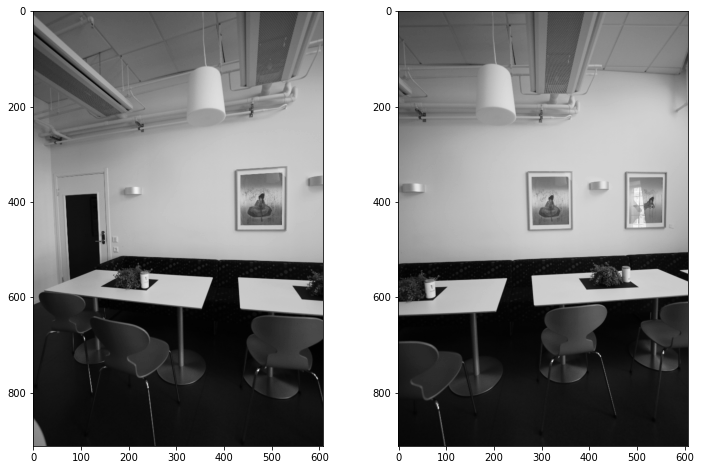

In [3]:
# Load our images
img1 = cv2.imread("stitch_l.png")
img2 = cv2.imread("stitch_m.png")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plot_two_imgs(img1_gray, img2_gray)

## Ключевые точки и дескрипторы

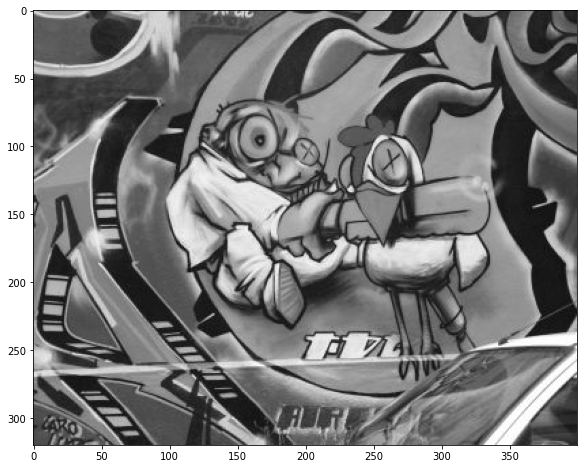

In [4]:
# Read image
img1 = cv2.imread('feat_input.jpg', 0)
plt.imshow(img1)

[[  0.8660254    0.5        -53.20508076]
 [ -0.5          0.8660254  121.43593539]]


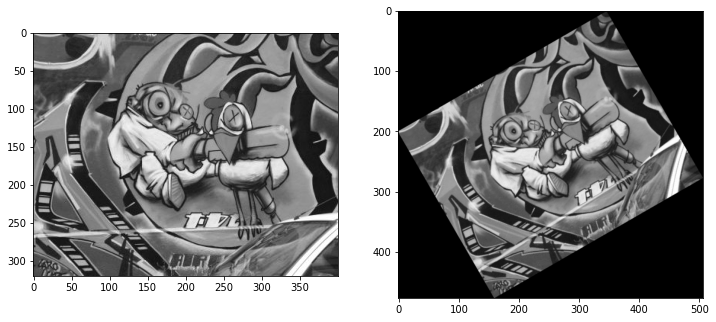

In [5]:
# rotate image
rows, cols = img1.shape
M = cv2.getRotationMatrix2D((cols/2, rows/2), 30, 1)
img2 = cv2.warpAffine(img1, M, (cols, rows))

print(M)

# find new width, height
new_w = int(rows * abs(M[0,1]) + cols * abs(M[0,0]))
new_h = int(rows * abs(M[0,0]) + cols * abs(M[0,1]))

# shift from old image center to the new image center
M[0, 2] += new_w/2 - cols/2
M[1, 2] += new_h/2 - rows/2

# rotate image with new shape and adjusted rotation matrix
img2 = cv2.warpAffine(img1, M, (new_w, new_h))

plot_two_imgs(img1, img2)

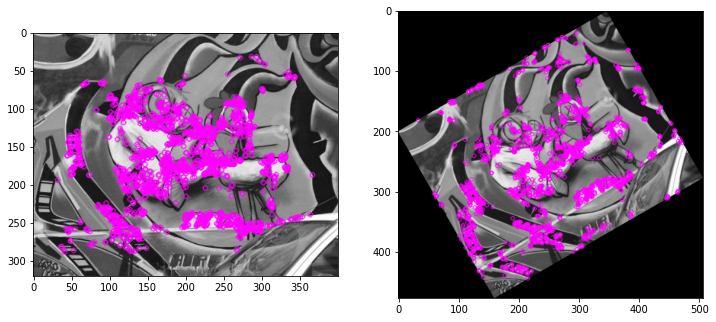

In [6]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1, None)

# Draw keypoints on the image
res1 = cv2.drawKeypoints(img1, kp1, None, (255, 0, 255))

# find the keypoints and descriptors on the rotated image
kp2, des2 = orb.detectAndCompute(img2, None)

# Draw keypoints on the rotated image
res2 = cv2.drawKeypoints(img2, kp2, None, (255, 0, 255))

plot_two_imgs(res1, res2)

In [7]:
def drawMatches(img1, keypoints1, img2, keypoints2, matches):
    r, c = img1.shape[:2]
    r1, c1 = img2.shape[:2]

    # Create a blank image with the size of the first image + second image
    output_img = np.zeros((max([r, r1]), c+c1, 3), dtype='uint8')
    output_img[:r, :c, :] = np.dstack([img1, img1, img1])
    output_img[:r1, c:c+c1, :] = np.dstack([img2, img2, img2])

    # Go over all of the matching points and extract them
    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx
        (x1, y1) = keypoints1[img1_idx].pt
        (x2, y2) = keypoints2[img2_idx].pt

        # Draw circles on the keypoints
        cv2.circle(output_img, (int(x1),int(y1)), 4, (0, 255, 255), 1)
        cv2.circle(output_img, (int(x2)+c,int(y2)), 4, (0, 255, 255), 1)

        # Connect the same keypoints
        cv2.line(output_img, (int(x1),int(y1)), (int(x2)+c,int(y2)), (0, 255, 255), 1)

    return output_img

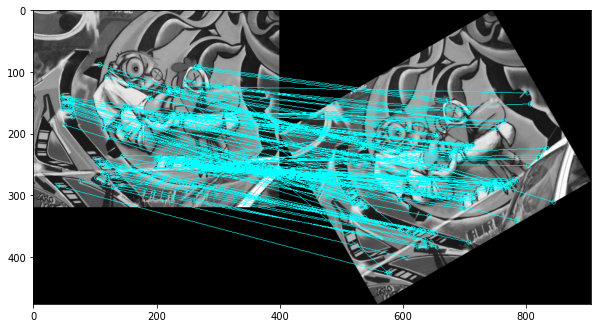

In [8]:
# compute feature matching
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

all_matches = []
for m, n in matches:
    all_matches.append(m)

# draw matching results with the given drawMatches function
res3 = drawMatches(img1, kp1, img2, kp2, all_matches[:150])
plt.imshow(res3)

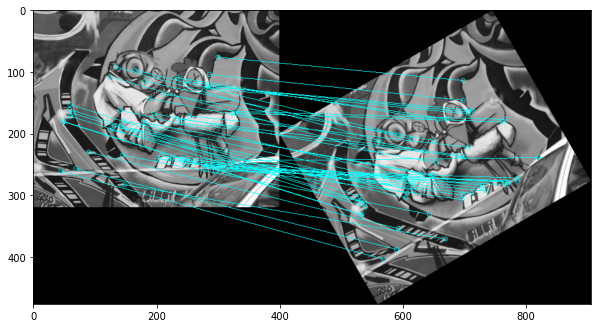

In [9]:
# Apply ratio test
good_matches = [] # Append filtered matches to this list
for m, n in matches:
    if m.distance < 0.4 * n.distance:
        good_matches.append(m)

# draw matching results with the given drawMatches function
res3 = drawMatches(img1, kp1, img2, kp2, good_matches)
plt.imshow(res3)

Transformation Matrix = 
 [[ 8.62000442e-01  4.94187865e-01  1.16008848e+00]
 [-4.99701281e-01  8.64434405e-01  1.99288549e+02]
 [ 1.18950773e-06 -1.35878046e-05  1.00000000e+00]]


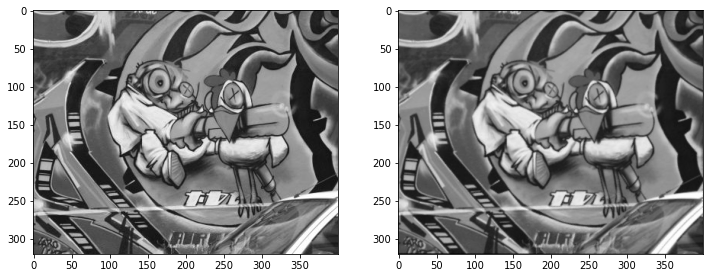

In [10]:
# estimate similarity transform
if len(good_matches) > 5:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    # find perspective transform matrix
    rot, mask = cv2.findHomography(src_pts, dst_pts)
    print("Transformation Matrix = \n", rot)
    
    # mapping rotated image back with the calculated rotation matrix
    res4 = cv2.warpPerspective(img2, np.linalg.inv(rot), (img1.shape[1], img1.shape[0]))
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),4))


plot_two_imgs(img1, res4)

## Склейка изображений

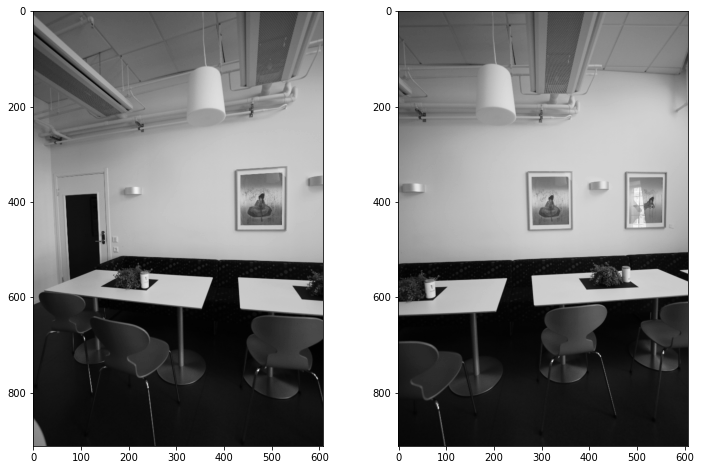

In [11]:
# Load our images
img1 = cv2.imread("stitch_l.png")
img2 = cv2.imread("stitch_m.png")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plot_two_imgs(img1_gray, img2_gray)

In [12]:
# Create our ORB detector and detect keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

# Find the key points and descriptors with ORB
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

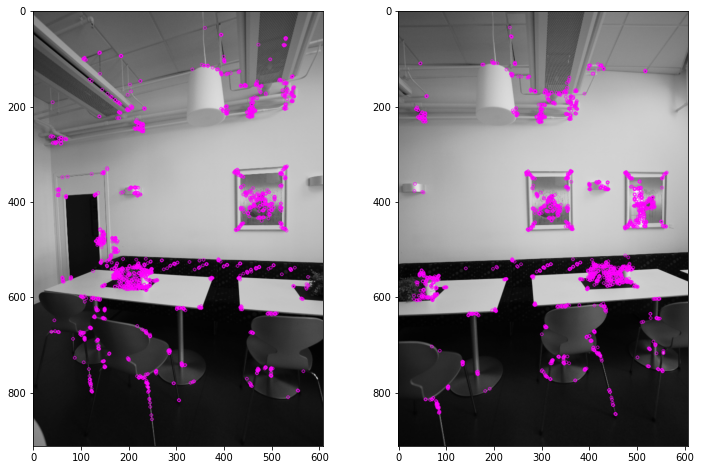

In [13]:
plot_two_imgs(cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255)), 
             cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255)))

In [14]:
# Create a BFMatcher object.
# It will find all of the matching keypoints on two images
bf = cv2.BFMatcher()

# Find matching points
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

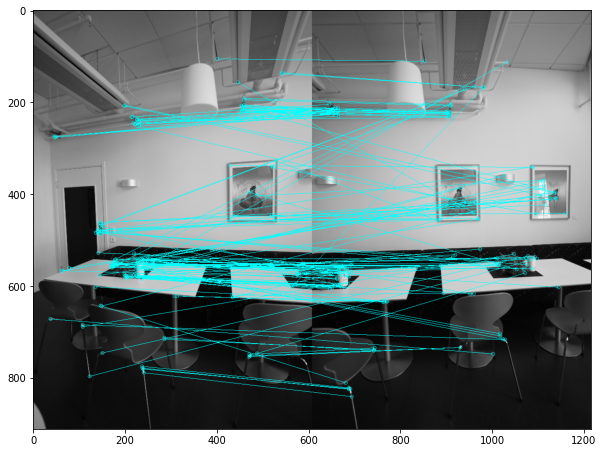

In [15]:
all_matches = []
for m, n in matches:
    all_matches.append(m)

img3 = drawMatches(img1_gray, keypoints1, img2_gray, keypoints2, all_matches[:150])
plt.imshow(img3)

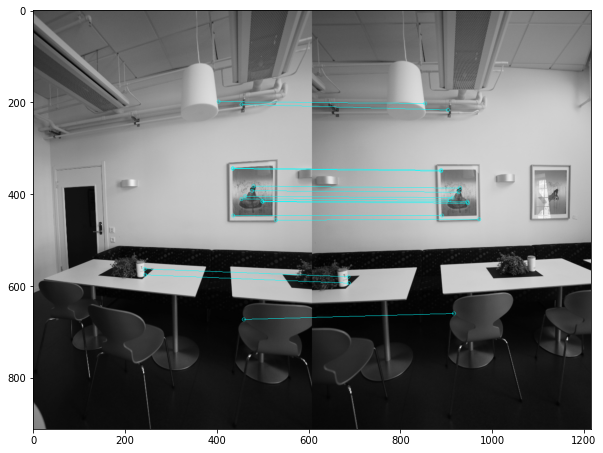

In [16]:
# Finding the best matches
good_matches = []
for m, n in matches:
    if m.distance < 0.5 * n.distance:
        good_matches.append(m)
        
        
img3 = drawMatches(img1_gray, keypoints1, img2_gray, keypoints2, good_matches)
plt.imshow(img3)

Transformation Matrix = 
 [[ 1.67699878e+00  3.65776678e-02 -3.28065127e+02]
 [ 4.61050025e-01  1.43110328e+00 -1.78229165e+02]
 [ 1.08383613e-03  1.84348799e-05  1.00000000e+00]]


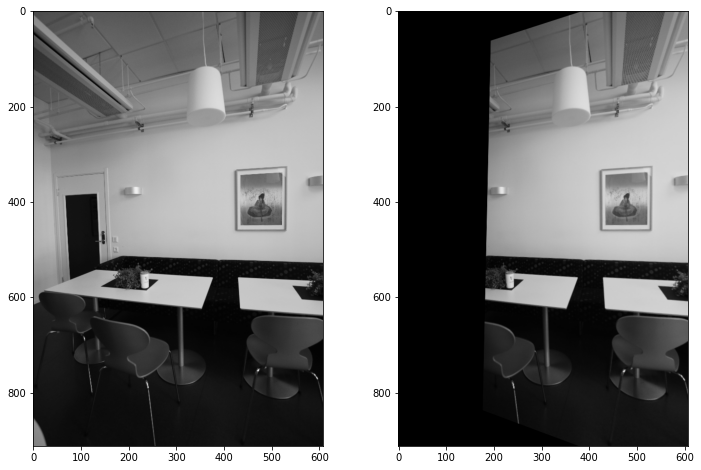

In [17]:
# estimate similarity transform
if len(good_matches) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
    # find perspective transform matrix
    rot, mask = cv2.findHomography(src_pts, dst_pts)
    print("Transformation Matrix = \n", rot)
    
    # mapping rotated image back with the calculated rotation matrix
    res4 = cv2.warpPerspective(img2, np.linalg.inv(rot), (img1.shape[1], img1.shape[0]))
else:
    print("Not enough matches are found - %d/%d" % (len(good_matches),4))


plot_two_imgs(img1, res4)

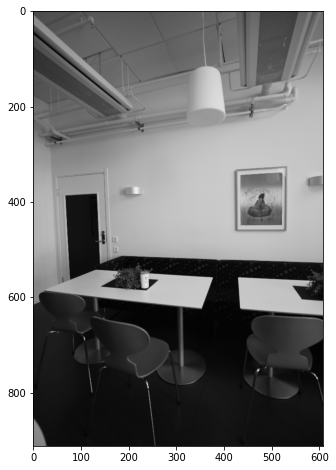

In [18]:
# Blend left and center
stitched_res = cv2.addWeighted(img1, 1, res4, 0, 0.0)
plt.imshow(stitched_res)